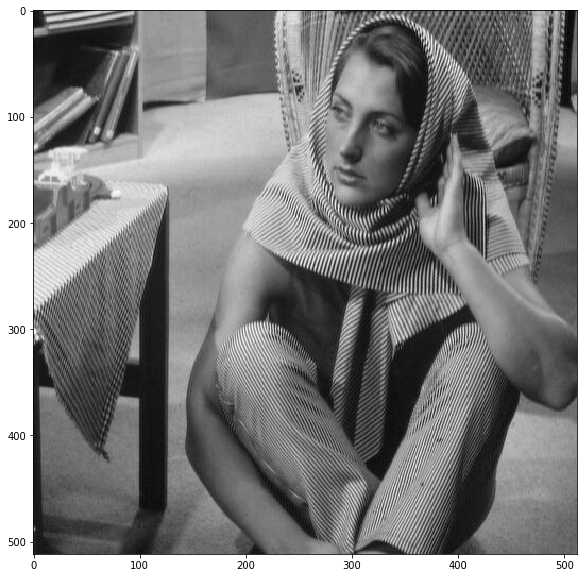

In [17]:
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# Open barbara image
img_jpg = mpimg.imread("barbara.jpg")
img_hr = rgb2gray(img_jpg)

# plot image
def plotImage(img):
    fig = plt.figure(figsize=(10,10))
    plt.gray()  
    plt.imshow(img)
    plt.show() 
    
plotImage(img_hr)

Convolve the image

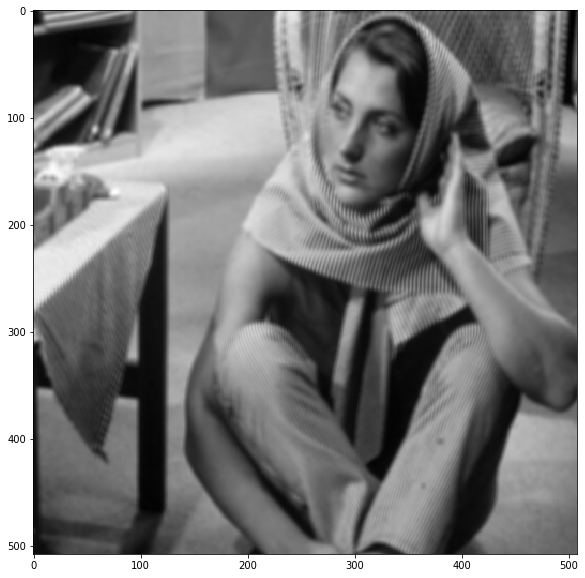

In [18]:
from scipy import signal

img_conv = scipy.signal.convolve2d(img_hr, np.ones((5,5)), mode='valid')  

plotImage(img_conv)

On decale l'image

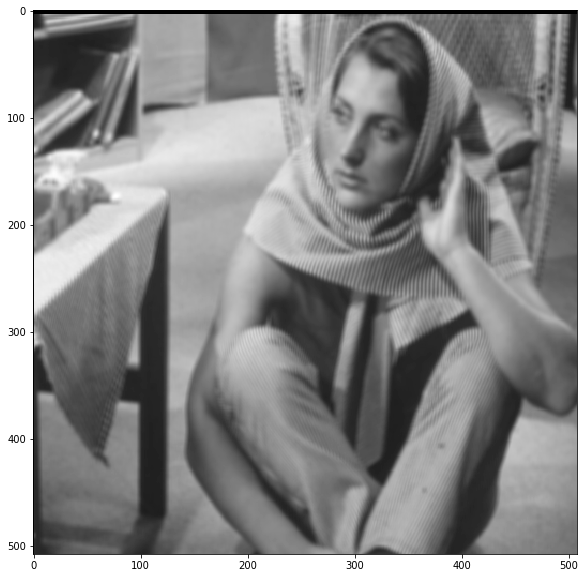

In [19]:
import numpy as np

rows, cols = img_conv.shape

translations = [(0,0),(0,1),(4,1),(1,4)]

img_trans = []
for translation in translations:
    img_trans.append(scipy.ndimage.shift(img_conv, translation))
    
plotImage(img_trans[2])

Down Sampling

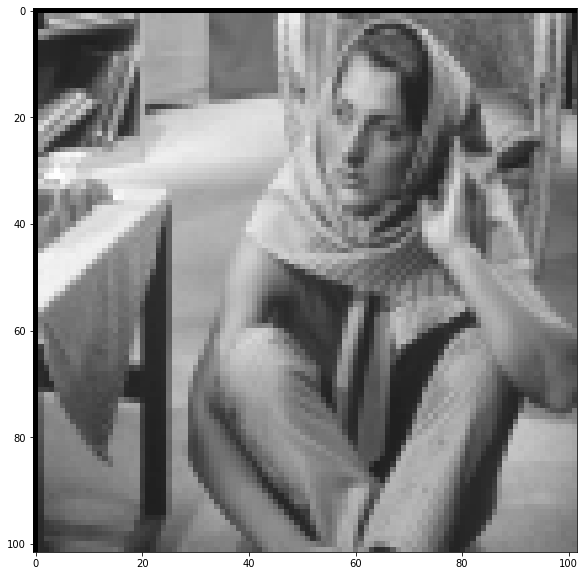

In [20]:
step = 5
img_downs = []
for img_tran in img_trans:
    img_downs.append(img_tran[:img_tran.shape[0]:step, :img_tran.shape[1]:step])

plotImage(img_downs[2])

Add noise

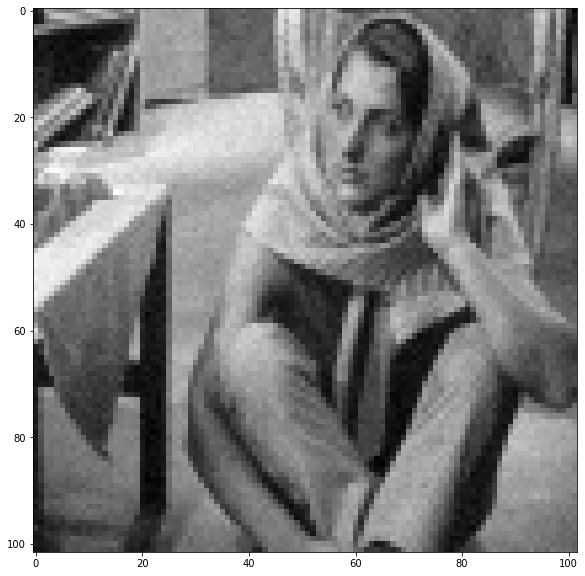

In [21]:
img_brs = []
for img_down in img_downs:
    img_brs.append(img_down + np.random.normal(size=img_down.shape, scale=100))

plotImage(img_brs[0])

Image a trou

In [113]:
x=img_brs[0]

In [115]:
x[0][1]

1603.8618262923414

In [135]:
def translation(x,y):
    w=[]
    for i in range(len(x)):
        for j in range(len(x)):
            w.append((x[i][j]-np.mean(x))*(y[i][j]-np.mean(y)))       
    
    r=np.sum(w)/(np.std(x)*np.std(y))
    return r

In [139]:
translation(img_brs[0],img_brs[3])

8868.847383156563

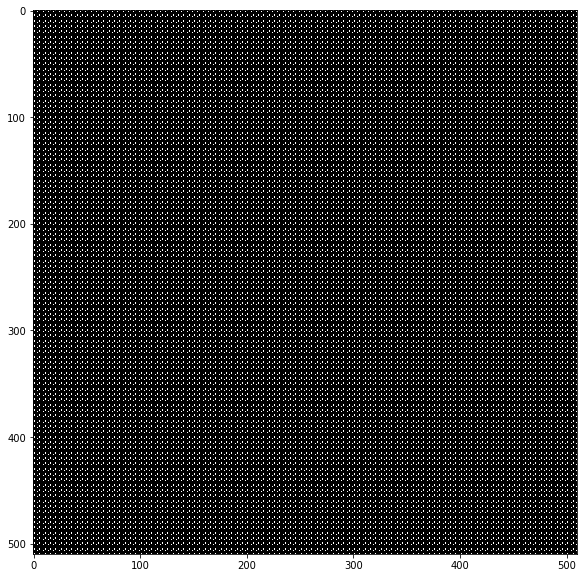

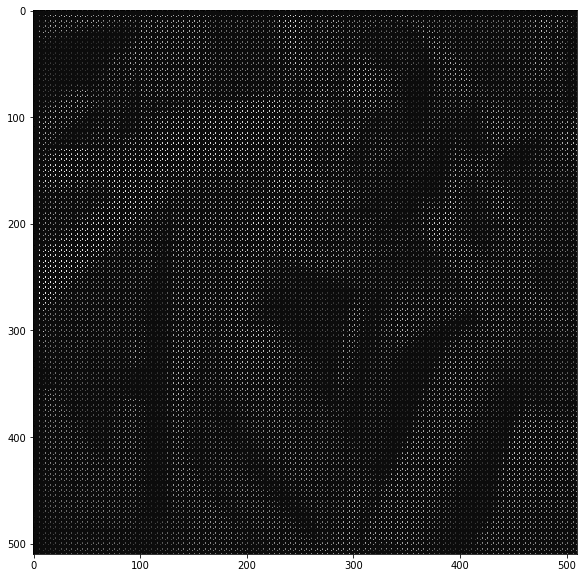

In [7]:
# Matrix
shape = [img_brs[0].shape[0]*step, img_brs[0].shape[1]*step]

M = np.zeros(shape=shape)
# Image composée des 3 images basse resolution
img_sum = np.zeros(shape=shape)

index = 0
for x,y in translations:
    M[x:shape[0]:step, y:shape[1]:step] = 1
    img_sum[x:shape[0]:step, y:shape[1]:step] += img_brs[index]
    index += 1

plotImage(M)   

# plot image
fig = plt.figure(figsize=(10,10))
plt.gray()  
plt.imshow(img_sum)
plt.show()

In [8]:
x

1

Inpainting

In [9]:
print(shape)
print(M.shape)

[510, 510]
(510, 510)


In [11]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
# initialize z
z = np.zeros(shape=shape)

import numpy as np
import matplotlib.pyplot as pp

# gradient of f(x)= A'(Ax - b)   
def grf(A,x,b):
    return A.T.dot(A.dot(x) - b)

ProjC  =  lambda  f ,  Omega :  M * f  +  ( 1 - M ) * y


for t in range(100):
    z=z-1/np.linalg.norm(M)
    

In [34]:
import numpy as np
import matplotlib.pyplot as pp

# Objective function: f(x) + lambda*norm1(x)
def obj(A,x,b,lamda):
    
    return f(A,x,b) + lamda*np.sum(np.abs(x))

# f(x) = (1/2)||Ax-b||^2
def f(A,x,b):
    
    Ax_b = A.dot(x) - b
    return 0.5*(Ax_b.T.dot(Ax_b))

# gradient of f(x)= A'(Ax - b)   
def grf(A,x,b):
    
    return A.T.dot(A.dot(x) - b)
    
# Model function evaluated at x and touches f(x) in xk
def m(x,xk,A,b,GammaK):
    
    innerProd = grf(A,xk,b).T.dot(x - xk)
    xDiff = x - xk
    return f(A,xk,b) + innerProd + (1.0/(2.0*GammaK))*xDiff.T.dot(xDiff)

# Shrinkage or Proximal operation
def proxNorm1(y,lamda):
    
    return np.sign(y)*np.maximum(np.zeros(np.shape(y)),np.abs(y)-lamda)


# Define parameters. Size of A is n x p
p = 1000
n = 500
kMax = 500   # Number of iteration
beta = 0.75 # decreasing factor for line search
# Generate the sparse vector xStar
# and Randomly set 20 elements
xStar = np.zeros((p,1))
xStar[np.floor(p*np.random.rand(20,1)).astype(np.int)]=1
xStar = xStar*np.random.normal(0,10,(p,1))

# Generate A and b. b = Ax + error
A = M
b = z
# This lamda is too large and making the x vector zero every time
lamda = np.sqrt(2*n*np.log(p)).tolist()
#lamda = 1.

# Proximal Gradient Descent
xk = img_sum # Initialize with random
#xk = np.zeros((p,1))      # Initialize with zero

for k in range(kMax):
    Gammak = 0.01
    #Gammak = 1/np.linalg.norm(A.T.dot(A))      

    # Line search
    while True:
        #print 'trying stepsize = ', "{0:0.2e}".format(Gammak),
        x_kplus1 = xk - Gammak*grf(A,xk,b)        # Gradient Descent (GD) Step
        if f(A,x_kplus1,b) <= m(x_kplus1,xk,A,b,Gammak):
            #print ' success'
            break
        else:
            #print ' Fail ',
            Gammak = beta*Gammak
    x_kplus1 = proxNorm1(x_kplus1,Gammak*lamda)   # Proximal Operation (Shrinkage)

    # Terminating Condition        
    Dobj = np.linalg.norm(obj(A,x_kplus1,b,lamda) - obj(A,xk,b,lamda))
    print ('k:',k, ' obj = ', obj(A,x_kplus1,b,lamda), 'Change = ',Dobj)
    if(Dobj<0.1):
        break

    # Update xk
    xk = x_kplus1 

    # Graphical Display        
    pp.figure(2)
    pp.clf()        
    pp.subplot(211)    
    pp.plot(xStar)
    pp.title('Original x')
    pp.subplot(212)
    pp.plot(xk)
    pp.title('Reconstructed x')
    pp.draw()
    pp.pause(0.1)
    pp.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [18]:
import cv2
img_hr_est = cv2.inpaint(np.uint8(img_sum), np.uint8(M), 5, cv2.INPAINT_TELEA)

# plot image
plotImage(img_hr_est)

ModuleNotFoundError: No module named 'cv2'

In [ ]:
prox_tv._prox_tv.tvp_2d

# initialize z
z = np.zeros(shape=shape)



for t in range(100):
    x = xt
    gradient = np.transpose(M)*(y-M*xt)
    z = xt - gradient
    xtt = rox_tv._prox_tv.tvp_2d(z)
    xtt = xtt + (t/t+4)*(xt-xtt) 

    